# Q1 – How do socioeconomic factors impact national team performance?

This notebook explores how national socioeconomic conditions relate to FIFA World Cup performance over time.

It relies on one input dataset: `merge_wc_with_socioeconomic.csv`, which contains the following (world cup year, team) level information:

- **World Cup performance** measured by maximum stage reached 
- **Normalized socioeconomic indicators** (GDP per capita, HDI, life expectancy, mean years of schooling) measured in the tournament year and for each of the preceding three years.

The dataset includes all countries that qualified for at least one world cup between 1994 and 2022.

The analysis is organized into four parts:

1. **Data preparation** – build analysis-ready tables for:
   - *All countries*, to use in charts that compare socioeconomic indicators between countries that qualified vs did not qualify.
   - *Qualified teams only*, to use in charts that compare socieconomic indicators across different stages of a world cup.
2. **Box plots** – compare distributions of socioeconomic indicators:
   - Between teams that qualified vs did not qualify  
   - Across stages among qualified teams
3. **Stacked bar charts** – visualize how the **quartile composition** of teams changes by qualification status and stage
4. **Ordinal probit regression** – estimate how a composite socioeconomic index predicts the probability of reaching key tournament milestones

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from pathlib import Path
from matplotlib.colors import ListedColormap
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FormatStrFormatter
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [2]:
# Define directories as global variables
BASE_DIR = Path(__file__).resolve().parents[2] if "__file__" in globals() else Path.cwd()
while not (BASE_DIR / "data").exists():
    BASE_DIR = BASE_DIR.parent
SAVE_DIR = BASE_DIR / "plots" / "q1_analysis" # Directory to save plots
SAVE_DIR.mkdir(parents=True, exist_ok=True)

## 1. Data Preparation

### 1.1 Create analysis flags and 3-year “growth” variables

We start from `wc_socio_merged`, which already contains:

- `max_stage` / `max_stage_numeric`: the furthest stage reached by each team in each World Cup  
- Normalized socioeconomic indicators in levels:
  - `norm_gdp_per_capita_tminus0`
  - `norm_hdi_tminus0`
  - `norm_life_expectancy_tminus0`
  - `norm_mean_school_years_tminus0`
- The same normalized indicators three years earlier (`_tminus3`)

On top of these, we construct:

- **`qualified`** – a binary factor:
  - `"Did Not Qualify"` if `max_stage_numeric == 0`
  - `"Qualified"` otherwise
- **`stage_num_for_expansion`** – a numeric stage used only for expanding qualified teams to each stage they passed through:
  - Group stage, Round of 16, Quarterfinals keep their own numeric stage  
  - The three placement stages are collapsed so that:
    - Fourth / Third place → Semi-final
    - Runner-up / Winner → Final & Winner
- **3-year normalized “growth” variables** for each socioeconomic indicator:
  - e.g. `gdp_per_capita_growth_3yr = norm_gdp_tminus0 − norm_gdp_tminus3`
  - These measure how far a country moved **up or down the global distribution**, in SD units, over the three years before the World Cup.


In [3]:
# Import input file
wc_socio_merged = pd.read_csv(BASE_DIR / "data/created_datasets/world_cup/merge_wc_with_socioeconomic.csv")

# Create a qualified vs did not qualify flag and create a variable indicating the stage that each team reached (slightly different from max_stage, used in qualified_teams_charting_data)
# Create 3-year delta for each socieconomic indicator - tells you whether a country moved up or down the global socioeconomic ladder
data_for_analysis = (
    wc_socio_merged
    .assign(qualified = lambda df: np.where(df['max_stage_numeric'] == 0, 
                                            'Did Not Qualify', 
                                            'Qualified'))
    .assign(stage_num_for_expansion = lambda df: np.select(
        condlist = [df['max_stage_numeric'] <= 3,
                    df['max_stage_numeric'] <= 5,
                    df['max_stage_numeric'] <= 7], 
        choicelist = [df['max_stage_numeric'],
                      4,
                      df['max_stage_numeric']-1]))
    .assign(gdp_per_capita_growth_3yr = lambda df: df['norm_gdp_per_capita_tminus0'] - df['norm_gdp_per_capita_tminus3'],
            hdi_growth_3yr = lambda df: df['norm_hdi_tminus0'] - df['norm_hdi_tminus3'],
            life_expectancy_growth_3yr = lambda df: df['norm_life_expectancy_tminus0'] - df['norm_life_expectancy_tminus3'],
            mean_school_years_growth_3yr = lambda df: df['norm_mean_school_years_tminus0'] - df['norm_mean_school_years_tminus3'])
)

# Make qualified an ordered categorical variable
data_for_analysis['qualified'] = pd.Categorical(
    data_for_analysis['qualified'], 
    categories=['Did Not Qualify','Qualified'], 
    ordered=True
)

### 1.2 Analysis datasets

We construct two analysis tables:

#### `all_teams_charting_data`

- One row per **country–World-Cup** combination
- Columns:
  - `world_cup_year`, `team`
  - `qualified` (“Did Not Qualify” vs “Qualified”)
  - Normalized level variables (`norm_*_tminus0`)
  - 3-year growth variables (`*_growth_3yr`)

This table is used to compare **countries that qualified vs those that did not**.

In [4]:
socio_cols_pattern = r'^(norm_|.*growth_3yr$)'

all_teams_charting_data = (
    data_for_analysis
    .loc[:, ['world_cup_year', 'team', 'qualified'] + data_for_analysis.filter(regex = socio_cols_pattern).columns.tolist()]
    .sort_values(by = ['world_cup_year', 'team'])
)

#### `qualified_teams_charting_data`

- Restricted to **teams that qualified**
- Each team–year is **expanded** to appear once for *every stage it reached*:
  - If a team reached the Quarterfinals, it appears under:
    - Group Stage, Round of 16, Quarterfinal
  - If it reached the Final, it appears under all earlier knockout stages as well
- Key columns:
  - `stage_expanded_num`: numeric stage 1–6
  - `stage_expanded`: ordered categorical stage label  
    (`Group Stage`, `Round of 16`, `Quarterfinal`, `Semifinal`, `Final`, `Winner`)
  - Normalized level and growth variables as above

This table is used to compare **socioeconomic profiles across stages**, conditional on having qualified.

In [5]:
################# Charting data for qualified teams only
stage_ticks = list(range(1,7))
stage_labels = ["Group Stage","Round of 16","Quarterfinal","Semifinal","Final","Winner"]
stage_map    = dict(zip(stage_ticks,stage_labels))

expanded_rows = []
for _, row in data_for_analysis.iterrows():
    for stage_num in range(1, int(row.stage_num_for_expansion) + 1):

        r = row.copy()
        r["stage_expanded_num"] = stage_num                     
        r["stage_expanded"] = stage_map[stage_num]
        expanded_rows.append(r)

qualified_teams_charting_data = pd.DataFrame(expanded_rows).reset_index(drop = True)

# Make stage_expanded an ordered category for consistent plotting
qualified_teams_charting_data["stage_expanded"] = pd.Categorical(
    qualified_teams_charting_data["stage_expanded"],
    categories=stage_labels,
    ordered=True
)

qualified_teams_charting_data = (
    qualified_teams_charting_data
    .loc[:, ['world_cup_year', 'team', 'max_stage', 'stage_expanded_num', 'stage_expanded'] + qualified_teams_charting_data.filter(regex = socio_cols_pattern).columns.tolist()]
    .sort_values(by = ['world_cup_year', 'team', 'stage_expanded'])
)

A quick sanity check confirms that for each team and tournament, the number of rows in `qualified_teams_charting_data` matches the number of stages they should appear in.

In [6]:
sanity_check = (
    qualified_teams_charting_data
    .groupby(['world_cup_year', 'team', 'max_stage'])
    .size().reset_index(name = 'num_rows')
    .groupby(['world_cup_year', 'max_stage', 'num_rows'])
    .size().reset_index(name = 'instances')
    .sort_values(by = ['world_cup_year', 'num_rows'])
    
)
print(sanity_check)

    world_cup_year       max_stage  num_rows  instances
1             1994     Group stage         1          8
3             1994     Round of 16         2          8
2             1994  Quarter-finals         3          4
0             1994    Fourth place         4          1
5             1994     Third place         4          1
4             1994      Runners-up         5          1
6             1994          Winner         6          1
8             1998     Group stage         1         16
10            1998     Round of 16         2          8
9             1998  Quarter-finals         3          4
7             1998    Fourth place         4          1
12            1998     Third place         4          1
11            1998      Runners-up         5          1
13            1998          Winner         6          1
15            2002     Group stage         1         16
17            2002     Round of 16         2          8
16            2002  Quarter-finals         3    

The cell below defines some helper functions and global variables that are used across the charts.

In [7]:
# Mapping for cleaner labels
metric_labels = {
    "gdp_per_capita": "GDP Per Capita",
    "hdi": "HDI",
    "life_expectancy": "Life Expectancy",
    "mean_school_years": "Mean School Years"
}


# Helper to convert column names → human-readable text
def pretty_metric(metric):
    """
    Convert a raw metric column name into a cleaner human-readable label to use in charts.

    This function removes suffixes like `_tminus0`, `norm_`, and `_growth_3yr`,
    then maps the cleaned term to a descriptive label defined in `metric_labels`.

    Args:
        metric (str): Raw column name from one of the charting datasets

    Returns:
        str or None: A cleaned, human-readable metric label. Returns None
            if the cleaned name is not found in `metric_labels`.
    """
    base = metric.replace("_tminus0", "").replace("norm_","").replace("_growth_3yr", "")
    return metric_labels.get(base)


# Helper to quickly create subplot grids
def make_grid(nrows=2, ncols=2, figsize=(16, 12), sharey=False):
    """
    Create a grid of subplots and return the figure and a flattened axes array.

    Args:
        nrows (int, optional): Number of subplot rows. Defaults to 2.
        ncols (int, optional): Number of subplot columns. Defaults to 2.
        figsize (tuple, optional): Figure size in inches (width, height).
            Defaults to (16, 12).
        sharey (bool, optional): Whether to share the y-axis across subplots.

    Returns:
        tuple:
            fig (matplotlib.figure.Figure): The created figure.
            axes (np.ndarray): Flattened array of Axes objects.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=figsize, sharey=sharey)
    return fig, axes.flatten()

def save_figure(fig, filename):
    """
    Save a Matplotlib figure to the project's standard plot directory.

    Args:
        fig (matplotlib.figure.Figure): The figure to save.
        filename (str or None): Output filename (without directory).  
            If None, the function performs no action.

    Returns:
        None
    """

    if filename is None:
        return
    out_path = SAVE_DIR / filename
    fig.savefig(out_path, dpi=300, bbox_inches="tight")    

# Metrics to plot
non_growth_metrics = [
    "norm_gdp_per_capita_tminus0",
    "norm_hdi_tminus0",
    "norm_life_expectancy_tminus0",
    "norm_mean_school_years_tminus0"
]

growth_metrics = [
    "gdp_per_capita_growth_3yr",
    "hdi_growth_3yr",
    "life_expectancy_growth_3yr",
    "mean_school_years_growth_3yr"
]

## 2. Box Plots

We now visualize how socioeconomic indicators differ:

1. **Between teams that qualified vs did not qualify**
2. **Across stages for qualified teams**

For each of the four socioeconomic indicators (GDP per capita, HDI, life expectancy, mean school years) we generate:

- **Level plots**: normalized indicator in the World Cup year  
- **Growth plots**: change in normalized indicator over the past three years

In [16]:
# ############################################################
# #  BOX PLOTS
# ############################################################
def plot_box(df, x_axis_var, growth_flag=False, filename=None):
    """
    Generate a 2×2 grid of boxplots comparing socioeconomic variables
    across qualification categories or World Cup stages.

    The figure also overlays mean markers and applies dynamic y-axis labels.
    When `growth_flag=True`, the function uses 3-year socioeconomic deltas.

    Args:
        df (pd.DataFrame): Input dataset containing socioeconomic variables
            and either a 'qualified' or 'stage_expanded' column.
        x_axis_var (str): Column used for the x-axis. Must be either
            'qualified' or 'stage_expanded'.
        growth_flag (bool, optional): If True, plots growth_metrics; if False,
            plots non_growth_metrics. Defaults to False.
        filename (str or None): If provided, the figure is saved under this
            filename using `save_figure`.

    Returns:
        None
    """

    df = df.copy()

    fig, axes = make_grid(2, 2, figsize=(14, 10))

    box_color = "#5B8CC0"
    dot_color = "#0A3D91"

    if growth_flag:
        metrics = growth_metrics
        base_ylabel = "Past 3-Year Normalized Score Change"
        suptitle_txt_1 = "Distribution of Past 3-Year Normalized Socioeconomic Change"
    else:
        metrics = non_growth_metrics
        base_ylabel = ""
        suptitle_txt_1 = "Distribution of Normalized Socioeconomic Indicators"

    if x_axis_var == "qualified":
        x_label = "Qualification Status"
        suptitle_txt_2 = "Among Teams that Qualified vs Teams that Did Not Qualify"
    elif x_axis_var == "stage_expanded":
        x_label = "Stage"
        suptitle_txt_2 = "Among Teams At Each World Cup Stage"

    for ax, metric in zip(axes, metrics):

        sns.boxplot(data=df, x=x_axis_var, y=metric, ax=ax, color=box_color)

        sns.pointplot(
            data=df,
            x=x_axis_var,
            y=metric,
            estimator=np.mean,
            errorbar=None,
            markers="o",
            markersize=8,
            linestyles="",
            err_kws={"linewidth": 0},
            ax=ax,
            color=dot_color
        )

        clean = pretty_metric(metric)
        ax.set_title(clean, fontsize = 13)

        # Local Y-label logic (fix)
        if base_ylabel == "":
            local_ylabel = f"Normalized {clean}"
        else:
            local_ylabel = base_ylabel
        ax.set_ylabel(local_ylabel, fontsize = 13)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        ax.set_xlabel(x_label, fontsize = 13)
        ax.tick_params(axis="x", rotation=45, labelsize = 13)

        ymin, ymax = df[metric].min(), df[metric].max()
        pad = (ymax - ymin) * 0.1
        ax.set_ylim(ymin - pad, ymax + pad)

    mean_handle = mlines.Line2D([], [], color=dot_color, marker='o',
                                linestyle='None', markersize=8, label='Mean')

    fig.legend(handles=[mean_handle], loc='upper right', bbox_to_anchor=(0.98, 0.98))

    # Better title formatting
    title = f"{suptitle_txt_1}\n{suptitle_txt_2}"

    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.92])

    save_figure(fig, filename)
    plt.show()

### 2.1
**Qualified vs Did Not Qualify (levels)**  
- Across GDP, HDI, life expectancy, and education, countries that qualify tend to sit **well above the global average** (normalized > 0), while non-qualifiers are below or around the mean.  
- The spreads overlap, but medians and means are systematically higher for qualified teams.


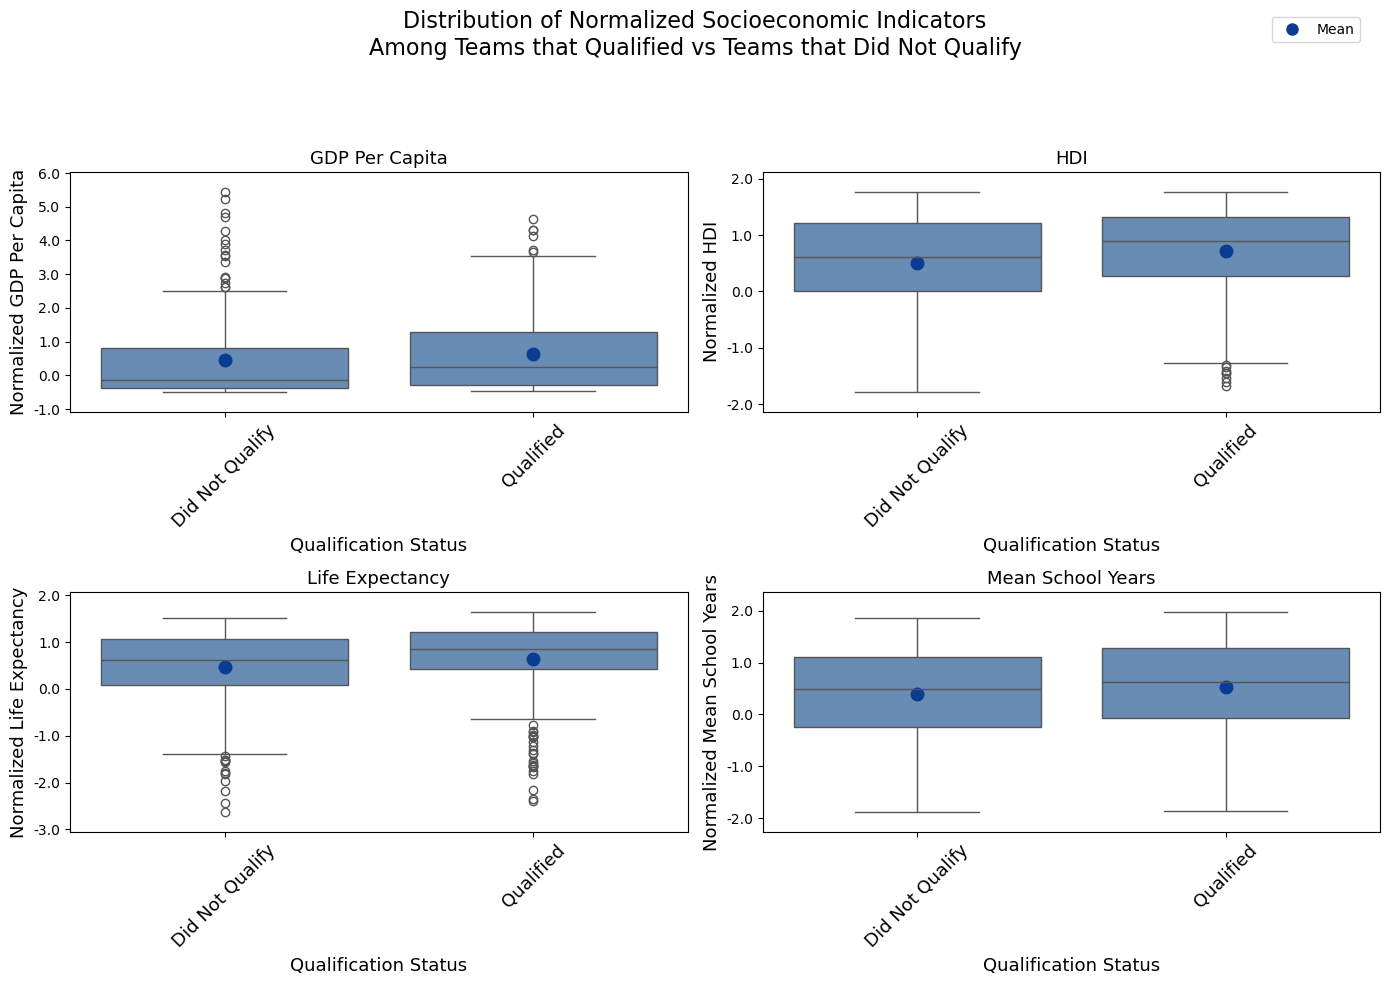

In [17]:
plot_box(all_teams_charting_data, 'qualified', False)

### 2.2
**Qualified vs Did Not Qualify (3-year change)**  
- Differences in **short-run improvements** are much smaller:
  - Qualified teams do not systematically experience faster 3-year gains than non-qualifiers.
  - Most of the “advantage” appears to come from **long-run structural differences**, not last-minute growth spurts.

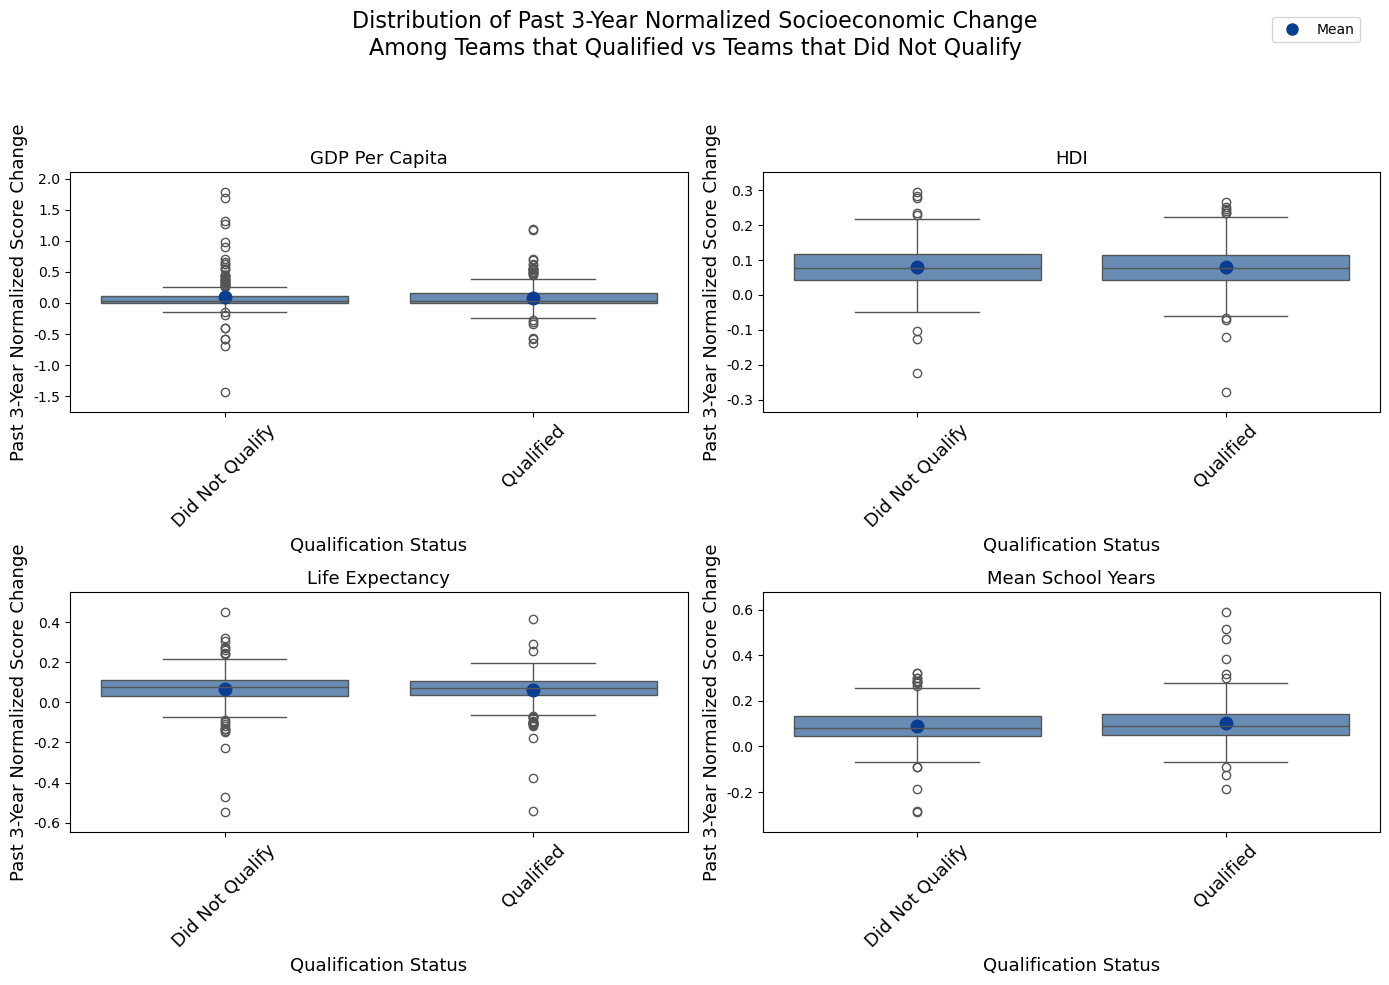

In [18]:
plot_box(all_teams_charting_data, 'qualified', True)

### 2.3
**By stage among qualified teams (levels)**  
- As we move from **Group Stage → Knockouts → Final / Winner**, the distributions shift upwards:
  - Teams reaching later stages have higher average normalized GDP, HDI, life expectancy, and education.
  - The lower tails are gradually trimmed: very low-socieconomic status ("SES") teams almost never reach the deepest stages.
- That said, the distributions retain substantial overlap: high-SES countries lose early, and occasionally mid-tier SES countries make surprising runs.


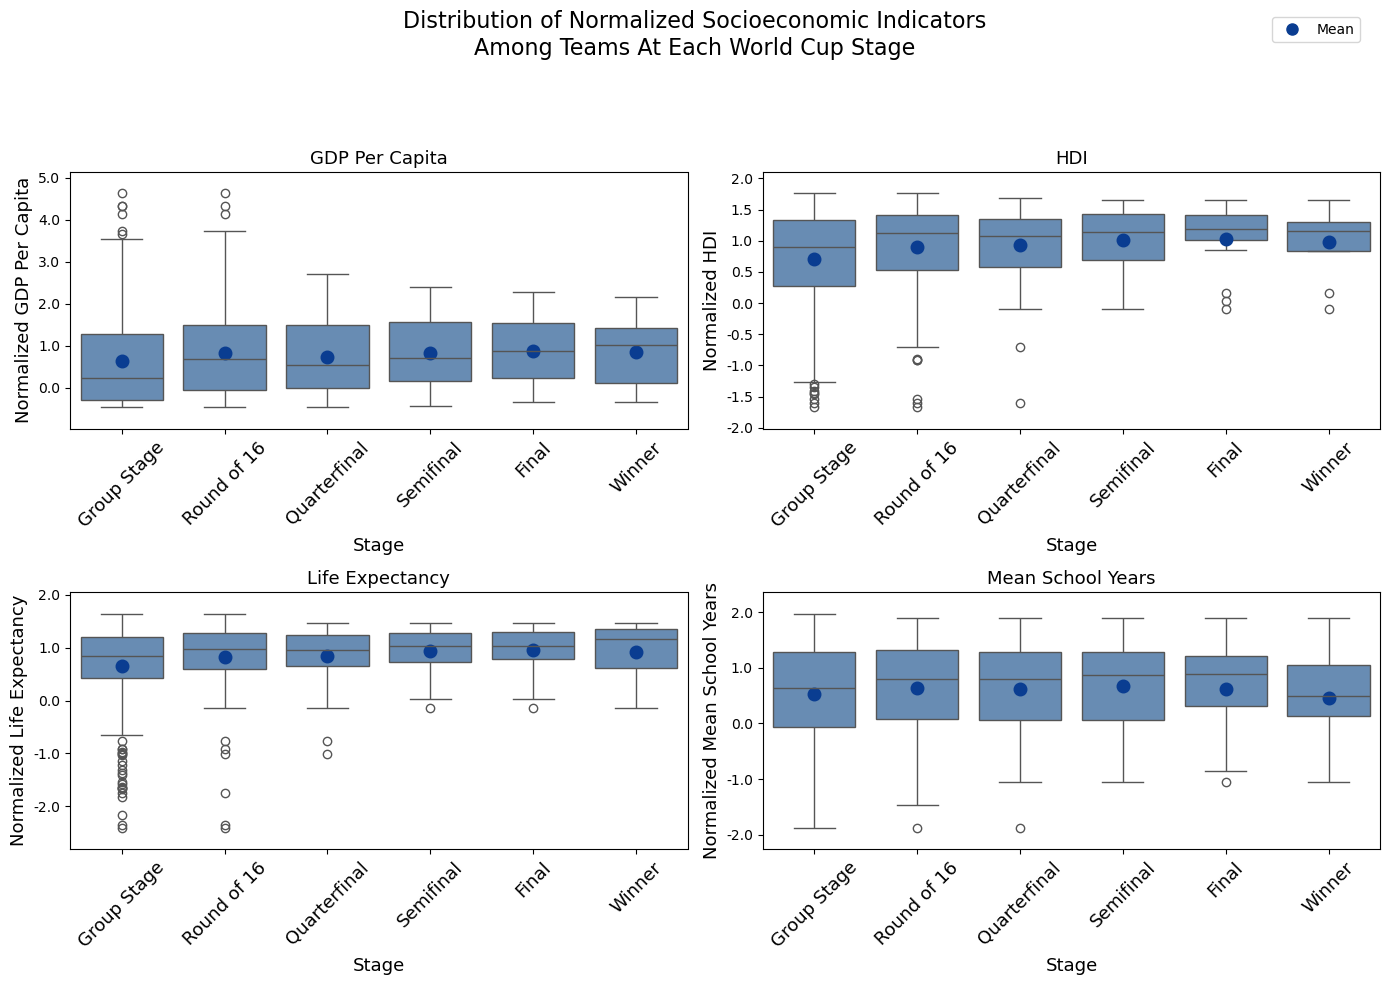

In [19]:
plot_box(qualified_teams_charting_data, 'stage_expanded', False)

### 2.4
**By stage among qualified teams (3-year change)**  
- The 3-year **normalized growth distributions** are broadly similar across stages:
  - No strong evidence that teams making deep runs are those with unusually rapid recent socioeconomic gains.
  - This supports the interpretation that **long-run level effects** matter more than short-run changes.

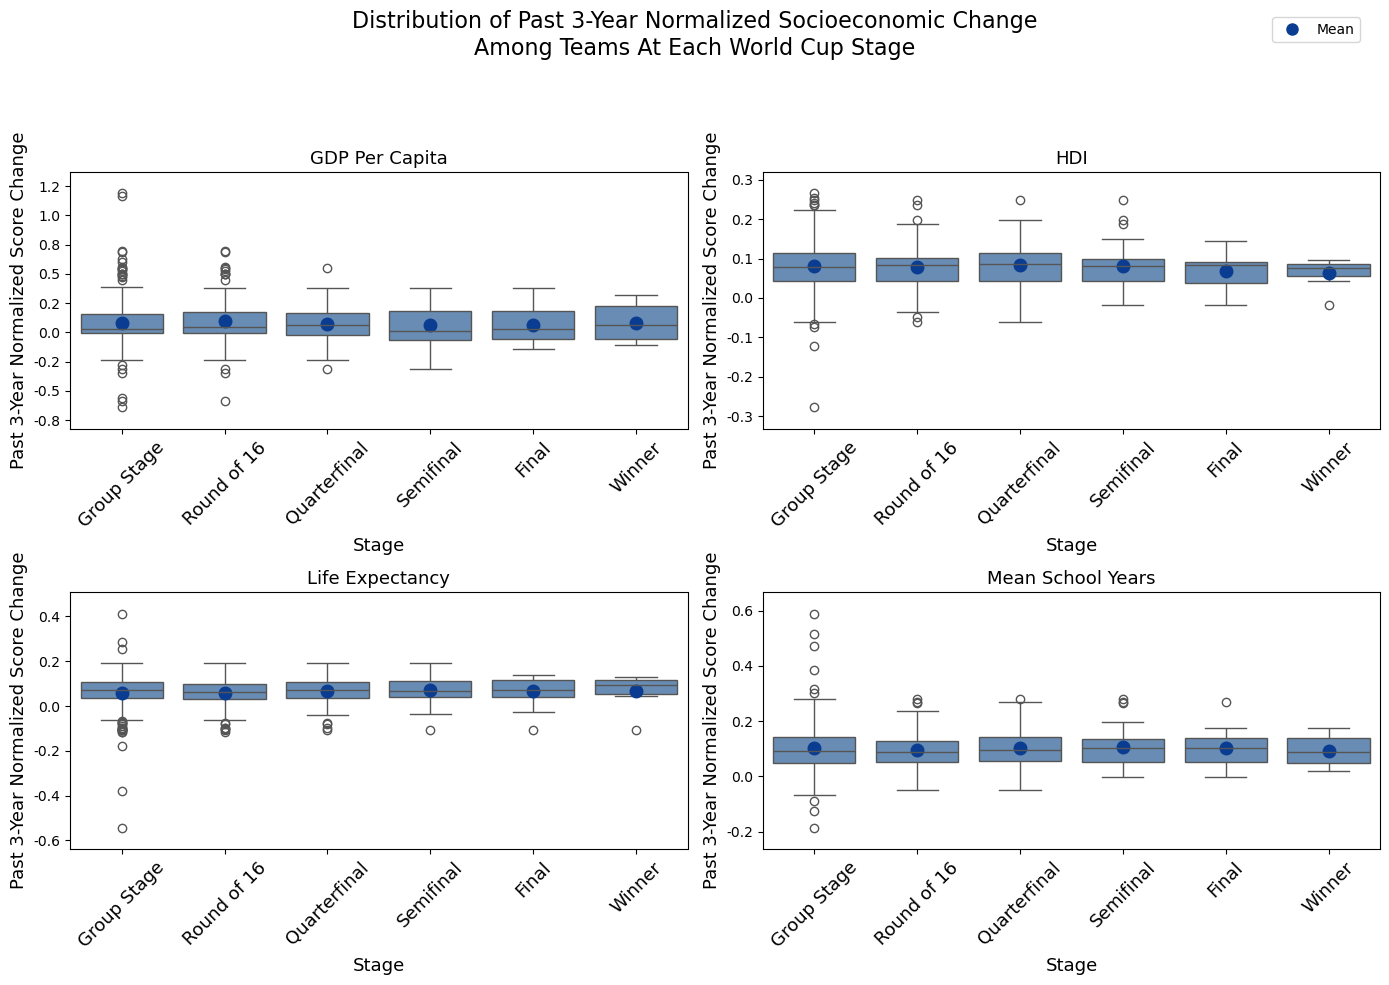

In [20]:
plot_box(qualified_teams_charting_data, 'stage_expanded', True)

## 3. Stacked Bar Charts – Quartile Composition

Box plots show the full distribution; stacked bar charts make it easier to see how the **share of teams in each socioeconomic quartile** changes with qualification status and stage.

For each indicator, we:

1. Compute **within-sample quartiles** of the normalized level variable (25%, 50%, 75% cut-points).
2. Assign every team to one of four percentile buckets (i.e., quartiles):
   - `0–25%`, `25–50%`, `50–75%`, `75–100%`
3. Within each group on the x-axis, compute the **proportion of teams** falling in each bucket.
4. Plot stacked bars using a consistent blue palette, formatted with y-axes as percentages.

`plot_stacked_bar` is called twice:

- Once with `x_axis_var="qualified"` – Qualified vs Did Not Qualify  
- Once with `x_axis_var="stage_expanded"` – Stage reached among qualified teams


In [25]:
# # ============================================================
# #       STACKED BAR CHART
# # ============================================================
quartile_colors = [
    "#DCE6F2",
    "#A9C2E3",
    "#5B8CC0",
    "#1F4F82"
]
quartile_cmap = ListedColormap(quartile_colors)

def plot_stacked_bar(df, x_axis_var, filename=None):
    """
    Plot 2×2 stacked bar charts showing the distribution of teams across
    socioeconomic quartiles for each metric.  Only considers levels (i.e. non_growth_metrics).

    Quartiles are computed independently for each metric using `pd.qcut`.
    Bars are grouped by qualification or World Cup stage.

    Args:
        df (pd.DataFrame): Input dataset containing socioeconomic variables
            and either 'qualified' or 'stage_expanded'.
        x_axis_var (str): Categorical variable on the x-axis. Must be either
            'qualified' or 'stage_expanded'.
        filename (str or None): If provided, the final figure is saved under
            this name in the standard plot directory.

    Raises:
        ValueError: If `x_axis_var` is not one of the accepted values.

    Returns:
        None
    """

    df = df.copy()

    metrics = non_growth_metrics
    suptitle_txt_1 = "Proportion of Teams in Each Socioeconomic Quartile"

    # Handle x-axis type (qualification vs stage)
    if x_axis_var == "qualified":
        x_label = "Qualification Status"
        suptitle_txt_2 = "Among Teams that Qualified vs Teams that Did Not Qualify"
        x_order = ['Did Not Qualify', 'Qualified']
    elif x_axis_var == "stage_expanded":
        x_label = "Stage"
        suptitle_txt_2 = "Among Teams At Each World Cup Stage"
        x_order = stage_labels
    else:
        raise ValueError("x_axis_var must be 'qualified' or 'stage_expanded'")

    # Ensure x-axis is categorical in correct order
    df[x_axis_var] = pd.Categorical(df[x_axis_var], categories=x_order, ordered=True)

    # Build percentile buckets
    q = 4
    bucket_labels = [f"{int(100*i/q)}-{int(100*(i+1)/q)}%" for i in range(q)]

    # Create subplots
    fig, axes = make_grid(2, 2, figsize=(14, 10))

    legend_handles = None

    for ax, metric in zip(axes, metrics):

        # Assign quartiles for each metric
        df[f"{metric}_bucket"] = pd.qcut(
            df[metric], q, labels=bucket_labels, duplicates="drop"
        )

        # Compute proportion inside each x-axis group
        temp = (
            df.groupby([x_axis_var, f"{metric}_bucket"], observed=True)
              .size()
              .reset_index(name="count")
        )

        temp["proportion"] = (
            temp.groupby(x_axis_var, observed = True)["count"].transform(lambda x: x / x.sum())
        )

        # Wide format for stacked bars
        wide = (
            temp.pivot(index=x_axis_var,
                       columns=f"{metric}_bucket",
                       values="proportion")
                .reindex(x_order)
        )

        # Human-readable label
        clean = pretty_metric(metric.replace("_tminus0","").replace("_growth_3yr",""))

        # Plot stacked bars
        barplot = wide.plot(
            kind="bar",
            stacked=True,
            colormap=quartile_cmap,
            width=0.90,
            ax=ax
        )

        # Capture legend only once
        if legend_handles is None:
            legend_handles = barplot.get_legend_handles_labels()

        # Formatting
        ax.set_title(f"{clean} Quartile Composition", fontsize=13)
        ax.set_xlabel(x_label, fontsize = 13)
        ax.set_ylabel("Share of Teams", fontsize = 13)
        ax.set_ylim(0, 1)
        ax.grid(axis='y', alpha=0.3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.tick_params(axis="x", rotation=45, labelsize = 13)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))

        ax.legend().remove()  # remove subplot legends

    # Global legend
    fig.legend(*legend_handles,
               title="Percentile Bucket",
               loc="upper right",
               bbox_to_anchor=(0.98, 0.97))

    # Combined title
    fig.suptitle(f"{suptitle_txt_1}\n{suptitle_txt_2}", fontsize=18)

    fig.tight_layout(rect=[0, 0, 0.92, 0.90])

    save_figure(fig, filename)
    plt.show()

### 3.1

**Qualification vs non-qualification**

- Non-qualifiers have a **higher share of teams in the bottom quartile** and **lower share of teams in the top quartile** for all four indicators.
- Qualified teams are disproportionately drawn from the **top half** of the global distributions:
  - Especially for GDP per capita and HDI, the 75–100% bucket is heavily over-represented among qualifiers.


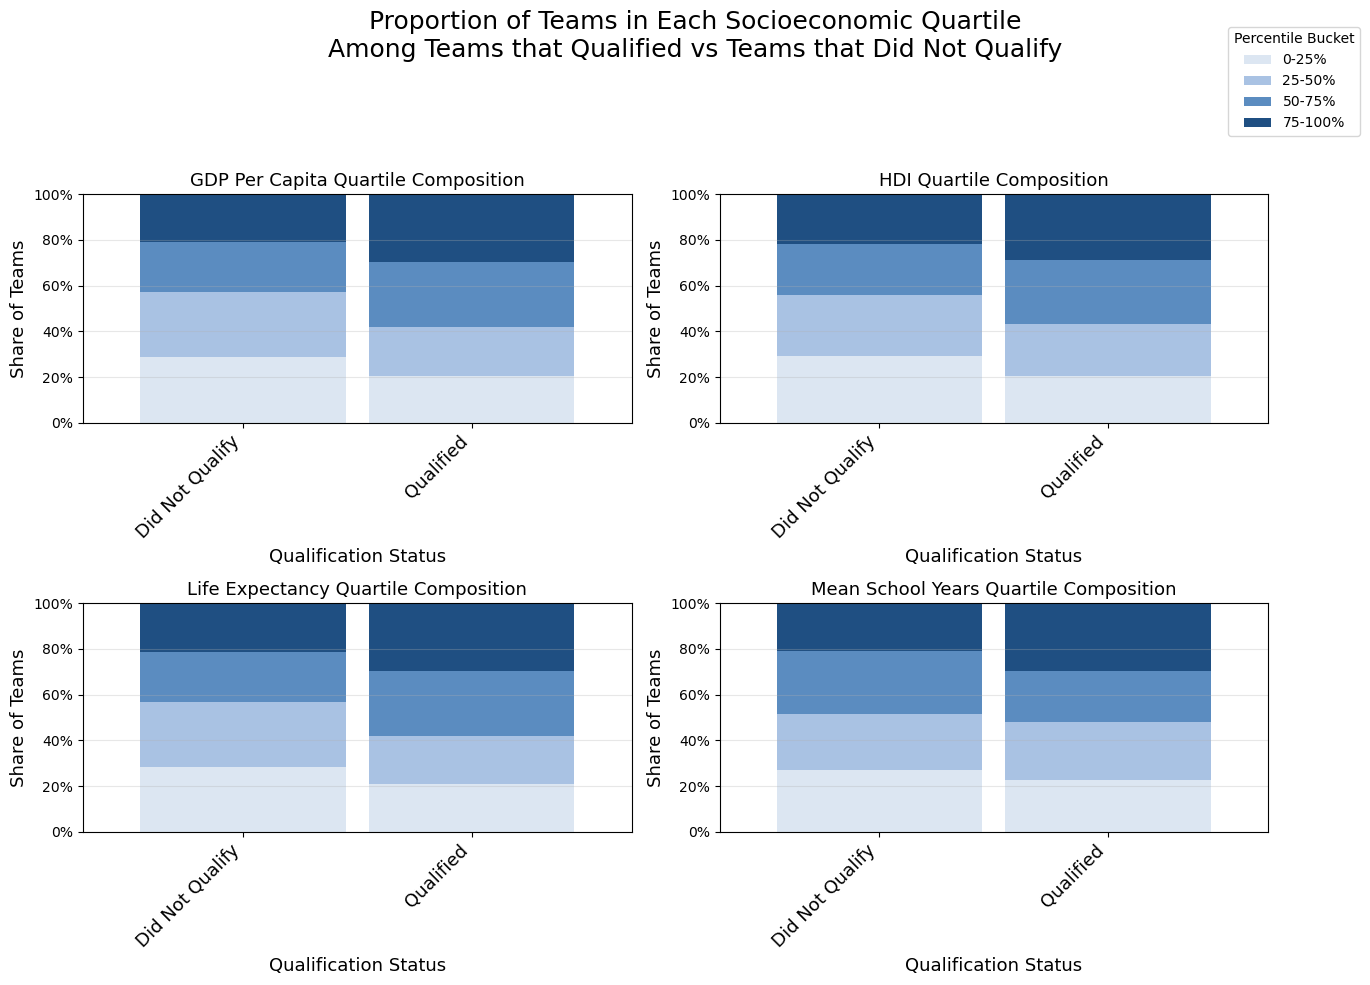

In [26]:
plot_stacked_bar(all_teams_charting_data, "qualified")

### 3.2
- From **Group Stage → Round of 16 → Quarterfinals**, the share of **bottom-quartile teams collapses**, while the **top-quartile share rises sharply**.
- At the very deepest stages (Semifinal, Final, Winner):
  - The sample is small, but the composition is heavily skewed toward **top-quartile countries**.
  - Nonetheless, a non-trivial fraction of semi-finalists and finalists come from the middle quartiles, consistent with upsets and variance in tournament play.

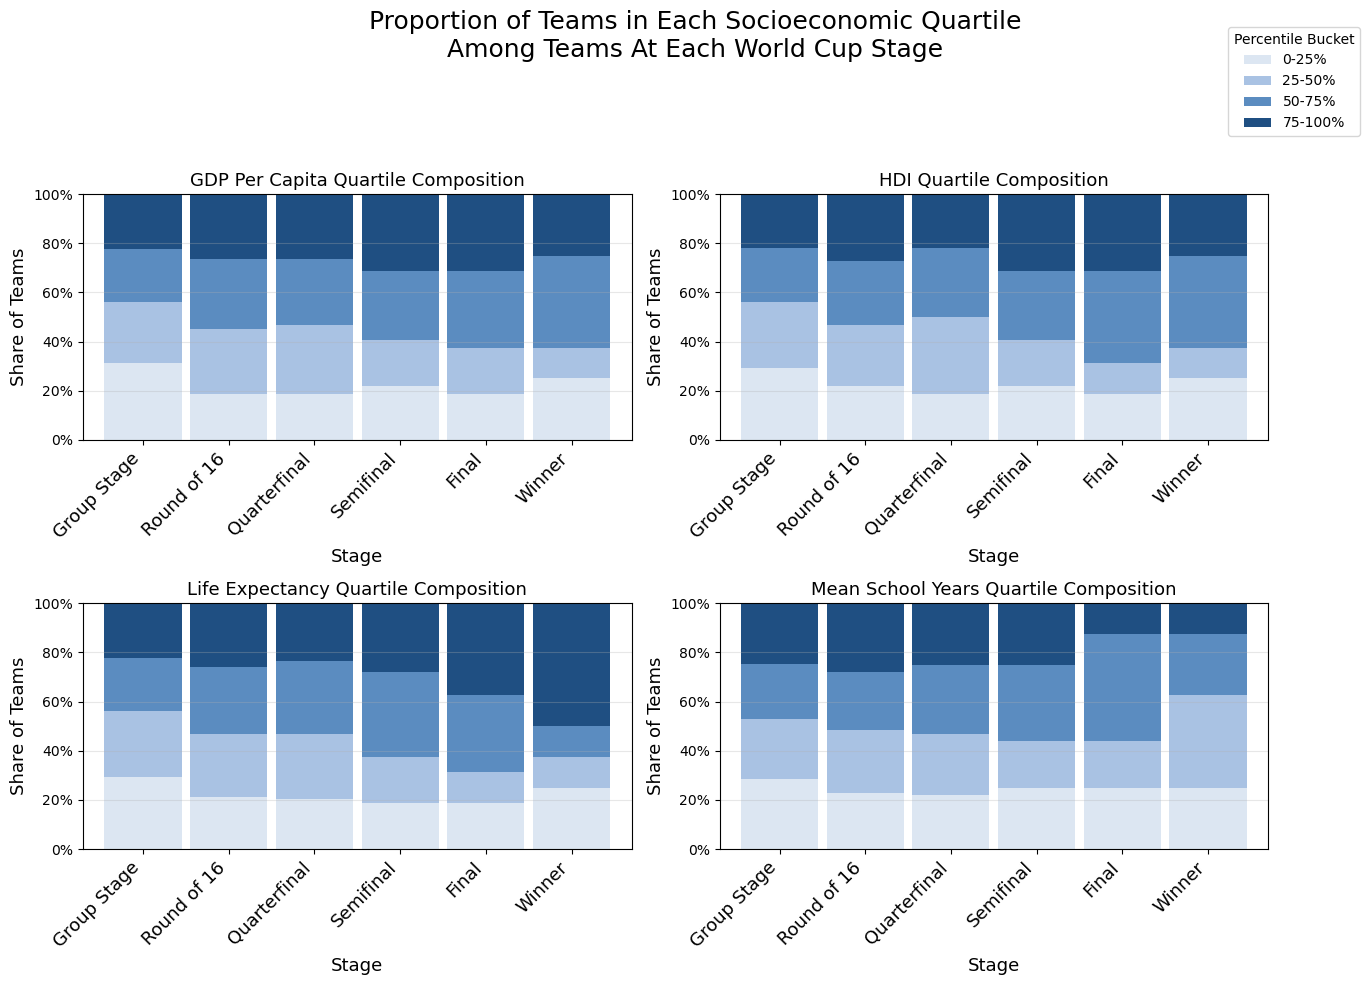

In [27]:
plot_stacked_bar(qualified_teams_charting_data, "stage_expanded")

## 4. Ordinal Probit Regression – Socioeconomic Index and Stage Reached

To summarize the relationship between socioeconomic status and performance in a single model, we estimate an **ordinal probit**:

- **Outcome**: `stage_expanded`  
  - Categorical with ordered levels:  
    Group Stage → Round of 16 → Quarterfinal → Semifinal → Final → Winner
- **Predictor**: `socio_index`  
  - A composite socieconomic index, calculated as the **average** of the four normalized SES indicators in the tournament year  
  - Interpreted as a one-dimensional socioeconomic index (roughly, “how many SDs above the global average this country sits overall”)

#### 4.1 Motivation for using a composite index instead of including each indicator as a separate regressor:

Using `qualified_teams_charting_data` we compute the correlation matrix of:

- Normalized GDP per capita
- Normalized HDI
- Normalized life expectancy
- Normalized mean school years

We then visualize the matrix with a heatmap.

The resulting correlations are quite high (especially HDI with education and life expectancy), which motivates the use of a **single composite socioeconomic index** in the regression instead of including all four predictors simultaneously (which would suffer from multicollinearity).

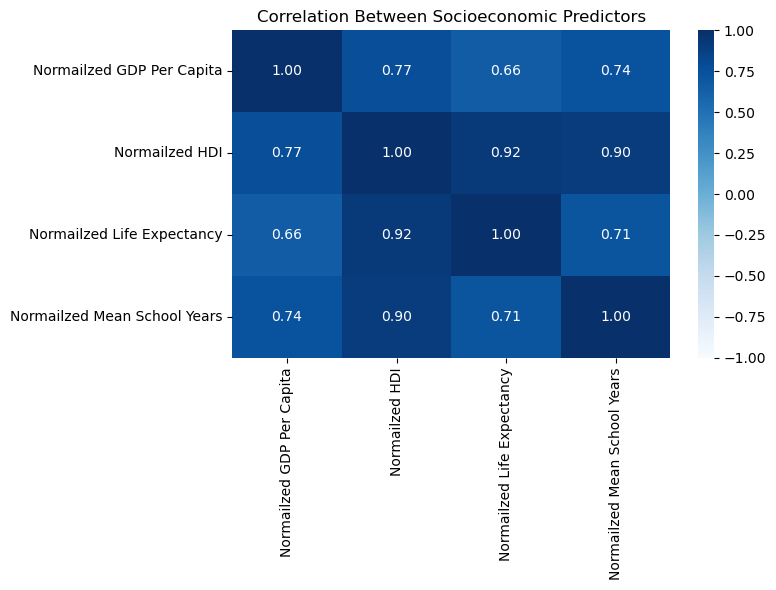

In [16]:
# ############################################################
# #  CORRELATION MATRIX FOR NORMALIZED SOCIECONOMIC VARIABLES
# ############################################################

# # ##### Check correlation between socioeconomic indicators for multicollinearity
fig, ax = plt.subplots(figsize=(8, 6))

# 1. Compute correlation matrix
corr = qualified_teams_charting_data[non_growth_metrics].corr()

# 2. Apply pretty_metric() to row/column labels
pretty_names = ["Normailzed " + pretty_metric(col) for col in corr.columns]
corr.index = pretty_names
corr.columns = pretty_names

# 3. Plot heatmap
sns.heatmap(
    corr,
    annot=True,
    cmap="Blues",
    vmin=-1,
    vmax=1,
    ax=ax,
    fmt=".2f"
)

ax.set_title("Correlation Between Socioeconomic Predictors")
plt.tight_layout()
plt.show()

### 4.2 Probit Model

The ordinal probit model implicitly assumes that (1) the maximum stage reached by a team is entirely determined by a latent, continuous performance variable (Y), with "cutoffs" defining which stage a team reaches.  It then models this latent performance variable as a linear function of the composite socieconomic index X (Y = BX).  For a given value of X, it predicts Y = BX, assumes a normal distribution centered at BX, and then consequently calculates the probability of each stage under that distribution.


=== SES Coefficient ===
Coefficient (β): 0.2722
P-value: 0.0023

=== Estimated Thresholds (τ) ===
τ1: 0.1293
τ2: 0.8371
τ3: 1.3264
τ4: 1.7201
τ5: 2.0544


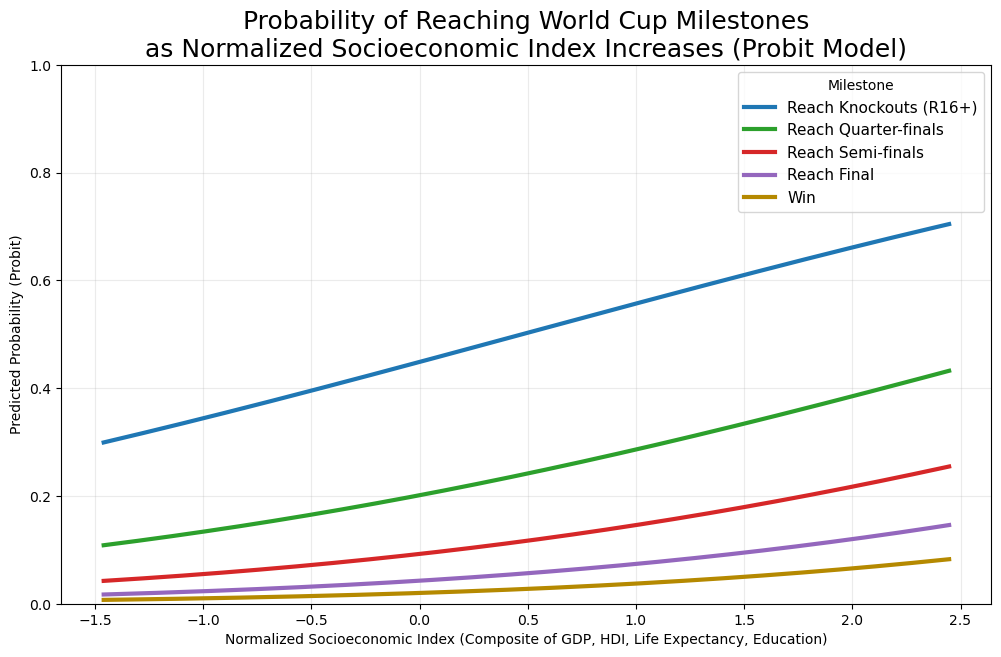

In [17]:
# ############################################################
# #  ORDINAL PROBIT REGRESSION
# ############################################################

# Keep only the row corresponding to the latest stage reached for each (world_cup_year, team)
df_reg = (
    qualified_teams_charting_data[['world_cup_year', 'team', 'stage_expanded_num', 'stage_expanded'] + non_growth_metrics]
    .dropna()
    .sort_values(["world_cup_year", "team", "stage_expanded"])
    .groupby(["world_cup_year", "team"], as_index=False)
    .tail(1)   # keep the row with the max stage_expanded_num
)

# Create a composite score that is the average of the normalized values across all four indicators
df_reg["socio_index"] = df_reg[non_growth_metrics].mean(axis=1)

# Run ordered logistic model
model = OrderedModel(df_reg['stage_expanded'], df_reg[['socio_index']],
                     distr='probit').fit(method = 'bfgs', disp = False)

# Print out model results
coef = model.params['socio_index']
pval = model.pvalues['socio_index']
print("\n=== SES Coefficient ===")
print(f"Coefficient (β): {coef:.4f}")
print(f"P-value: {pval:.4f}")
delta_names = [name for name in model.params.index if '/' in name]
deltas = model.params[delta_names].values
taus = [None for i in range(len(deltas))]
for i in range(len(deltas)):
    if i == 0:
        taus[i] = deltas[i]
    else:
        taus[i] = taus[i-1] + np.exp(deltas[i])
print("\n=== Estimated Thresholds (τ) ===")
for i, t in enumerate(taus, start=1):
    print(f"τ{i}: {t:.4f}")


# Create a series of socio_economic index values
x_vals = np.linspace(df_reg["socio_index"].min(), df_reg["socio_index"].max(), 300)
exog = pd.DataFrame({"socio_index": x_vals})
# predict the probability of reaching each stage (same number of rows as x_val, one column for each stage)
pred = model.predict(exog=exog, which="prob")

# Probability of reaching AT LEAST a given milestone
p_knockout = pred.iloc[:, 1:].sum(axis=1)   # stage ≥ Round of 16
p_qf = pred.iloc[:, 2:].sum(axis=1)   # stage ≥ QF
p_sf = pred.iloc[:, 3:].sum(axis=1)   # stage ≥ SF
p_final = pred.iloc[:, 4:].sum(axis=1)   # stage ≥ Final
p_winner = pred.iloc[:, 5:] # Stage = winner


# === Plot === #
fig = plt.figure(figsize=(12,7))

plt.plot(x_vals, p_knockout, linewidth=3, label="Reach Knockouts (R16+)", color="#1f77b4")
plt.plot(x_vals, p_qf, linewidth=3, label="Reach Quarter-finals", color="#2ca02c")
plt.plot(x_vals, p_sf, linewidth=3, label="Reach Semi-finals", color="#d62728")
plt.plot(x_vals, p_final,linewidth=3, label="Reach Final", color="#9467bd")
plt.plot(x_vals, p_winner, linewidth = 3, label = "Win", color = "#b58900")

plt.title("Probability of Reaching World Cup Milestones\nas Normalized Socioeconomic Index Increases (Probit Model)", fontsize=18)
plt.xlabel("Normalized Socioeconomic Index (Composite of GDP, HDI, Life Expectancy, Education)")
plt.ylabel("Predicted Probability (Probit)")
plt.ylim(0,1)
plt.grid(alpha=0.25)
plt.legend(title="Milestone", fontsize=11)

plt.show()

### 4.3 Interpreting the milestone probability curves

- The estimated coefficient on `socio_index` is **positive and statistically significant**, indicating that higher socioeconomic status is associated with **better World Cup performance**, even after compressing outcomes to a single ordered scale.
- As the composite socioeconomic index rises:
  - The probability of **reaching the knockouts** increases from roughly 30% for low-SES teams to around 70%+ for high-SES teams.
  - The probability of reaching the **Quarterfinals** and **Semifinals** rises steadily but remains well below 50% even for very high-SES countries.
  - The probability of **winning** the World Cup remains low for all SES levels, though it is clearly higher for richer, healthier, more educated countries.

Overall, the ordinal probit model reinforces the descriptive plots:

> **Socioeconomic advantage strongly shifts the odds of going deep in the World Cup, but randomness and football-specific factors mean that no team is ever “guaranteed” success.**